# Latency Model for the RADOS Simulator
The latency model `latModel` has two components: one for converting request size into latency and another one to add compaction delays drawn from a heavy-tailed distribution (e.g. `random.lognormvariate(mu, sigma)`). See `scripts/radossim.py` for more details.

In [1]:
# Basic parameters
runs = 11

# latModel parameters (Fit those to an actual BlueStore deployment!)

# Log fitting for IO sizes > 64KB
lgMult = 820.28
lgAdd = -1114.3

# Linear fitting for IO sizes <= 64KB
smMult = 62.36
smAdd = 8.33

# Lognormal fitting to "In each second, at least 10 x 60ms are spent
# with the drive being blocked [skourtis:inflow13, Fig 4]"
# A rough example approximation would be an average around 10ms (i.e. 100 reqs/sec)
# with a 90%-tile around 60ms (so 10 of the 100 req/sec are at least 60ms)
# with the 99%-tile not too much higher. It all depends on the minimum throughput
mu = 9.9
sigma = 0.64

# Test for larger parameters
test_list = []


In [2]:
# Parameters
lgMult = 820.28
lgAdd = -1114.3
smMult = 62.36
smAdd = 8.33
mu = 6.0
sigma = 2.0


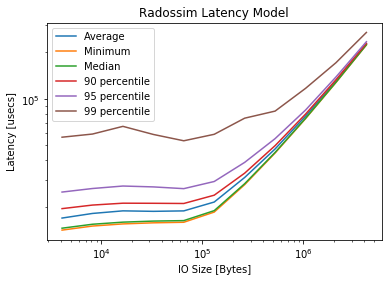

In [8]:
import matplotlib
import matplotlib.pyplot as plt

# Add path for modules in scripts/ so this notebook works
# without the context created by main.workflow
import sys
sys.path.append('../..')

import scripts.radossim as sim


x = []
y_min = []
y_avg = []
y_med = []
y_p90 = []
y_p95 = []
y_p99 = []
for i in range(runs):
    s = (2**i) * 4096
    x.append(s)
    msmts = []
    for j in range(10000):
        msmts.append(sim.latModel(s, lgMult, lgAdd, smMult, smAdd, mu, sigma))
    msmts.sort()
    avg = sum(msmts) / len(msmts)
    median = msmts[int(.5 * len(msmts))]
    pct90 = msmts[int(.90 * len(msmts))]
    pct95 = msmts[int(.95 * len(msmts))]
    pct99 = msmts[int(.99 * len(msmts))]
    y_min.append(msmts[0])
    y_avg.append(avg)
    y_med.append(median)
    y_p90.append(pct90)
    y_p95.append(pct95)
    y_p99.append(pct99)
    
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(x, y_avg, label='Average')
ax.plot(x, y_min, label='Minimum')
ax.plot(x, y_med, label='Median')
ax.plot(x, y_p90, label='90 percentile')
ax.plot(x, y_p95, label='95 percentile')
ax.plot(x, y_p99, label='99 percentile')
ax.set(xlabel='IO Size [Bytes]', ylabel='Latency [usecs]', title='Radossim Latency Model')

plt.legend()
plt.show()

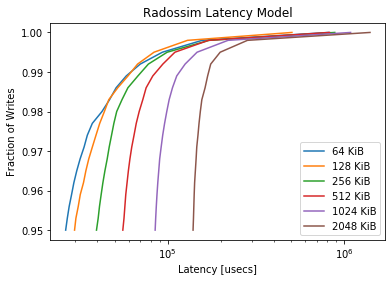

In [14]:
data = {}
for i in range(6):
    s = (2**i) * 64 * 1024
    msmts = []
    for j in range(10000):
        msmts.append(sim.latModel(s, lgMult, lgAdd, smMult, smAdd, mu, sigma))
    msmts.sort()
    data[s] = msmts

curve = {}
for i in range(6):
    s = (2**i) * 64 * 1024
    x = []
    y = []
    for i in range(950, 1000, 3):
        x.append(data[s][int(i/1000. * len(data[s]))])
        y.append(i/1000.)
    x.append(data[s][-1])
    y.append(1.0)
    curve[s] = (x, y)

fig, ax = plt.subplots()
ax.set_xscale('log')
for s in curve.keys():
    ax.plot(curve[s][0], curve[s][1], label='%d KiB' % (s / 1024))
ax.set(xlabel='Latency [usecs]', ylabel='Fraction of Writes', title='Radossim Latency Model')
plt.legend()
plt.show()